<a href="https://colab.research.google.com/github/shree180103/dcgan_mnist/blob/main/dcgan_with_fid_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import torchvision
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets

In [2]:
torch.cuda.is_available()

True

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
# x and y are concatenated and send as one img in the in the disc. thus input channels of disc are 3*2=6

In [4]:
class Discriminator(nn.Module):
  def __init__(self,input_shape:int):
    super().__init__()
    self.patch_gan=nn.Sequential(
        nn.Conv2d(in_channels=input_shape*2,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=1,padding=1,bias=False,padding_mode="reflect"),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=1,bias=False,padding_mode="reflect"),

    )

  def forward(self,x,y):
      x=torch.cat([x,y],dim=1)
      return self.patch_gan(x)


In [5]:
def test():
    x=torch.rand(size=(1,3,256,256)).to('cuda')
    y=torch.rand(size=(1,3,256,256)).to('cuda')
    model=Discriminator(input_shape=3).to('cuda')
    preds=model(x,y)
    print(preds.shape)

test()

torch.Size([1, 1, 30, 30])


In [6]:
class Generator(nn.Module):
  def __init__(self,img_channels):
    super().__init__()
    self.down_in=nn.Sequential(
        nn.Conv2d(in_channels=img_channels,out_channels=64,kernel_size=4,stride=2,bias=False,padding=1,padding_mode='reflect'), 
        nn.LeakyReLU(0.2,inplace=True)
    )

    self.down2=nn.Sequential(
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,bias=False,padding=1,padding_mode='reflect'),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True)
    )
      
    self.down3=nn.Sequential(
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,bias=False,padding=1,padding_mode='reflect'),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True)
    )

    self.down4=nn.Sequential(
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,bias=False,padding=1,padding_mode='reflect'),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True)
        
    )

    self.down5=nn.Sequential(
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=4,stride=2,bias=False,padding=1,padding_mode='reflect'),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True)
    )

    self.down6=nn.Sequential(
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=4,stride=2,bias=False,padding=1,padding_mode='reflect'),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True)
    )

    self.down_bn=nn.Sequential(
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=4,stride=2,bias=False,padding=1,padding_mode='reflect'),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True)
    )

    self.bottle_neck=nn.Sequential(
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=4,stride=2,bias=False,padding=1,padding_mode='reflect'),
        nn.LeakyReLU(inplace=True)
        
    )
    self.up_bn=nn.Sequential(
        nn.ConvTranspose2d(in_channels=512,out_channels=512,kernel_size=4,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
    )

    self.up2=nn.Sequential(
        nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
        
    )

    self.up3=nn.Sequential(
        nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
      
    )

    self.up4=nn.Sequential(
         nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
    )

    self.up5=nn.Sequential(
        nn.ConvTranspose2d(in_channels=1024,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True)
    )

    self.up6=nn.Sequential(
         nn.ConvTranspose2d(in_channels=512,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
        
        
    )

    self.up7=nn.Sequential(
        nn.ConvTranspose2d(in_channels=256,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    
    )

    self.up_out=nn.Sequential(
        nn.ConvTranspose2d(in_channels=128,out_channels=img_channels,kernel_size=4,stride=2,padding=1,bias=False),
        nn.Tanh()
        
    )

    self.dropout=nn.Dropout()
    



  def forward(self,x):
      d1=self.down_in(x)
      # print(d1.shape)
      d2=self.down2(d1)
      # print(d2.shape)
      d3=self.down3(d2)
      # print(d3.shape)
      d4=self.down4(d3)
      # print(d4.shape)
      d5=self.down5(d4)
      # print(d5.shape)
      d6=self.down6(d5)
      # print(d6.shape)
      d_bn=self.down_bn(d6)
      # print(d_bn.shape)
      bn=self.bottle_neck(d_bn)
      # print(bn.shape)
      u_bn=self.dropout(self.up_bn(bn))
      # print(u_bn.shape)
      u2=self.dropout(self.up2(torch.cat([u_bn,d_bn],dim=1)))
      # print(u2.shape)
      u3=self.dropout(self.up3(torch.cat([u2,d6],1)))
      # print(u3.shape)
      u4=self.up4(torch.cat([u3,d5],1))
      # print(u4.shape)
      u5=self.up5(torch.cat([u4,d4],1))
      # print(u5.shape)
      u6=self.up6(torch.cat([u5,d3],1))
      # print(u6.shape)
      u7=self.up7(torch.cat([u6,d2],1))
      return self.up_out(torch.cat([u7,d1],1))
      
      
      
      
                



In [7]:
def test():
    x=torch.rand(size=(1,3,256,256)).to('cuda')
    model=Generator(img_channels=3).to('cuda')
    preds=model(x)
    print(preds.shape)

test()

torch.Size([1, 3, 256, 256])


In [8]:
device="cuda" if torch.cuda.is_available() else "cpu"
# device="cpu"
n_c=3

gen=Generator(img_channels=n_c).to(device)
gen.apply(weights_init)

disc=Discriminator(input_shape=n_c).to(device)
disc.apply(weights_init)


Discriminator(
  (patch_gan): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_siz

In [9]:
device

'cuda'

In [10]:
from PIL import Image
import numpy as np
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
# training params
batch_size=16
lr=0.0002
img_size=256
n_c=3
lambda_l1=100



In [11]:
both_x_and_y_transform=A.Compose([A.Resize(width=256,height=256)],additional_targets={"image0":"image"})#seperating x and y

transform_X=A.Compose([A.Normalize([0.5 for _ in range(n_c)],[0.5 for _ in range(n_c)]),ToTensorV2()])
transform_Y=A.Compose([A.Normalize([0.5 for _ in range(n_c)],[0.5 for _ in range(n_c)]),ToTensorV2()])

In [12]:
from torchvision.utils import save_image
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class MapDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.input_files = os.listdir(self.input_dir)
        self.target_files = os.listdir(self.target_dir)

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, index):
        input_img_file = self.input_files[index]
        target_img_file = self.target_files[index]

        input_img_path = os.path.join(self.input_dir, input_img_file)
        target_img_path = os.path.join(self.target_dir, target_img_file)

        input_image = np.array(Image.open(input_img_path))
        target_image = np.array(Image.open(target_img_path))

        # Apply augmentations if necessary
        augmentations = both_x_and_y_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        # Apply specific transforms if needed
        input_image = transform_X(image=input_image)["image"]
        target_image = transform_Y(image=target_image)["image"]

        return input_image, target_image



# class MapDataset(Dataset):
#     def __init__(self, root_dir):
#         self.root_dir = root_dir
#         self.list_files = os.listdir(self.root_dir)

#     def __len__(self):
#         return len(self.list_files)

#     def __getitem__(self, index):
#         img_file = self.list_files[index]
#         img_path = os.path.join(self.root_dir, img_file)
#         image = np.array(Image.open(img_path))
#         input_image = image[:,:256,:]
#         target_image = image[:,256:, :]

#         augmentations = both_x_and_y_transform(image=input_image, image0=target_image)
#         input_image = augmentations["image"]
#         target_image = augmentations["image0"]

#         input_image = transform_X(image=input_image)["image"]
#         target_image = transform_Y(image=target_image)["image"]

#         return input_image, target_image


# if __name__ == "__main__":
#     dataset = MapDataset("data_maps/maps/maps/train/")
#     loader = DataLoader(dataset, batch_size=5)
#     for x, y in loader:
#         save_image(x, "x.png")
#         save_image(y, "y.png")
#         import sys

#         exit()

In [13]:
train_dataset=MapDataset(input_dir="data_comics/faces/",target_dir="data_comics/comics/")
train_data_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
val_dataset=MapDataset(input_dir="data_comics/val_faces/",target_dir="data_comics/val_comics/")
val_data_loader=DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True)


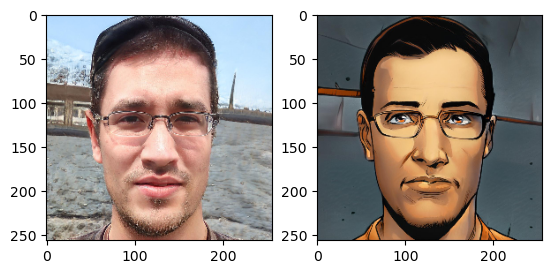

In [25]:
image,label=next(iter(train_data_loader))
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow((image[0]*0.5+0.5).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow((label[0]*0.5+0.5).permute(1,2,0))

plt.show()

In [16]:
# writer_fake=SummaryWriter("logs/GAN_MNIST/fake")

# writer_real=SummaryWriter("logs/GAN_MNIST/real")

# step = 0

# fixed_noise = torch.randn(size=(64,z_dim,1,1))

In [17]:
# z=torch.rand(size=(1,100,1,1))
# z.shape

In [18]:
# img,label=next(iter(data_loader))
# img.shape

In [19]:
# !pip install torchinfo

In [20]:
# from torchinfo import summary

# summary(disc,input_size=[1,3,64,64])

In [21]:
# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)


In [22]:
# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)

In [23]:
# summary(gen,input_size=[1,3,265,256])

In [24]:
# gen.eval()
# with torch.inference_mode():
#   print(gen(z.to('cuda')).shape)

In [26]:
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import inception_v3
from torchvision.models import Inception_V3_Weights
import scipy
import numpy as np

In [27]:
loss_fn=nn.BCEWithLogitsLoss()
loss_l1=nn.L1Loss()
optimizer_disc=torch.optim.Adam(params=disc.parameters(),lr=lr,betas=(0.5,0.999))
optimizer_gen=torch.optim.Adam(params=gen.parameters(),lr=lr,betas=(0.5,0.999))

In [28]:
from tqdm.auto import tqdm

epochs=30
LOSS_D=[]
LOSS_G=[]
fid_scores=[]

for epoch in tqdm(range(epochs)):
  for batch_idx,(x,y) in enumerate(train_data_loader):
    z=torch.randn(size=(batch_size,100,1,1),device=device)

    ## traing the discriminator

    disc.zero_grad()
    disc_real=disc(x.to(device),y.to(device))
    loss_disc_real=loss_fn(disc_real,torch.ones_like(disc_real))
      
    y_fake=gen(x.to(device))
    
    disc_fake=disc(x.to(device),y_fake.detach().to(device))
    loss_disc_fake=loss_fn(disc_fake,torch.zeros_like(disc_fake))

    loss_disc=(loss_disc_fake+loss_disc_real)/2
    LOSS_D.append(loss_disc.item())

    loss_disc.backward()

    optimizer_disc.step()

    #training generator
    gen.zero_grad()

    fool_logits=disc(x.to(device),y_fake.to(device))
    loss_gen=loss_fn(fool_logits,torch.ones_like(fool_logits))+loss_l1(y_fake.to(device),y.to(device))*lambda_l1
    
    LOSS_G.append(loss_gen.item())

    loss_gen.backward()

    optimizer_gen.step()

    if batch_idx== 0:
           
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_data_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )











  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [0/30] Batch 0/619                   Loss D: 0.8585, loss G: 55.2900
Epoch [1/30] Batch 0/619                   Loss D: 1.2719, loss G: 24.1241
Epoch [2/30] Batch 0/619                   Loss D: 1.1661, loss G: 22.7343
Epoch [3/30] Batch 0/619                   Loss D: 0.3393, loss G: 19.1147
Epoch [4/30] Batch 0/619                   Loss D: 0.3358, loss G: 21.5952
Epoch [5/30] Batch 0/619                   Loss D: 0.2545, loss G: 21.1405
Epoch [6/30] Batch 0/619                   Loss D: 0.6630, loss G: 18.4363
Epoch [7/30] Batch 0/619                   Loss D: 0.1524, loss G: 21.2392
Epoch [8/30] Batch 0/619                   Loss D: 0.3606, loss G: 19.0504
Epoch [9/30] Batch 0/619                   Loss D: 0.3994, loss G: 19.0901
Epoch [10/30] Batch 0/619                   Loss D: 0.4718, loss G: 19.8206
Epoch [11/30] Batch 0/619                   Loss D: 0.3699, loss G: 17.5516
Epoch [12/30] Batch 0/619                   Loss D: 0.6057, loss G: 16.5458
Epoch [13/30] Batch 0/

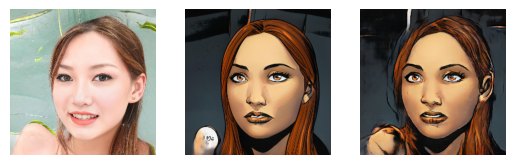

In [229]:
x,y=next(iter(train_data_loader))
import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.imshow((x[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow((y[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
y_fake=gen(x.to(device))
plt.subplot(1,3,3)
plt.imshow((y_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
plt.axis('off')
plt.show()


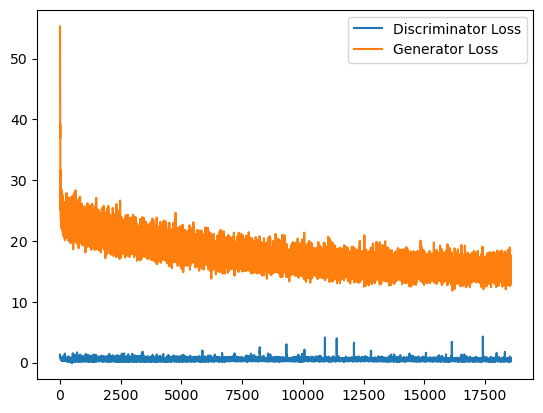

In [42]:
plt.plot(LOSS_D,label="Discriminator Loss")
plt.plot(LOSS_G,label="Generator Loss")
plt.legend()
plt.show()

In [30]:
# class PartialInceptionNetwork(nn.Module):
#   def __init__(self):
#     super(PartialInceptionNetwork, self).__init__()
#     self.inception_model = inception_v3(weights=Inception_V3_Weights.DEFAULT)  #initializing pretrsined model
#     self.inception_model.Mixed_7c.register_forward_hook(self.output_hook)
#     self.output = None

#   def output_hook(self, module, input, output):
#     self.mixed_7c_output = output

#   def forward(self, x):
#     assert x.shape[1:] == (3, 299, 299), "Input shape should be (batch_size, 3, 299, 299)"
#     self.inception_model(x)
#     activations = self.mixed_7c_output
#     activations = F.adaptive_avg_pool2d(activations, (1, 1))
#     activations = activations.view(x.shape[0],2048)
#     return activations

# net=PartialInceptionNetwork().to(device)

# def fid_score(real_images, gen_images,batch_size):
#   real_activations = []
#   gen_activations = []
#   num_steps=int(math.ceil(float(len(real_images))/float(batch_size)))
#   for i in range(num_steps):
#     s = i * batch_size
#     e=(1+i) * batch_size

#     mini_real_batch=real_images[s:e]
#     mini_gen_batch=gen_images[s:e]

#     batch_real=Variable(mini_real_batch).to(device)
#     batch_gen=Variable(mini_gen_batch).to(device)

#   features_real=net(batch_real)
#   features_gen=net(batch_gen)

#   real_activations.append(features_real)
#   gen_activations.append(features_gen)

#   features_real=torch.cat(real_activations,0)
#   features_gen=torch.cat(gen_activations,0)

#   xr=features_real.cpu().detach().numpy()
#   xg=features_gen.cpu().detach().numpy()

#   u1=np.mean(xr,axis=0)
#   u2=np.mean(xg,axis=0)
#   s1=np.cov(xr,rowvar=False)
#   s2=np.cov(xg,rowvar=False)
#   print(s1.shape)
#   print(s2.shape)

#   diff=u1-u2
#   diff_squared=diff.dot(diff)

#   prod=np.dot(s1,s2)

#   sqrt_prod,_=scipy.linalg.sqrtm(prod,disp=False)

#   if np.iscomplexobj(sqrt_prod):
#       sqrt_prod=sqrt_prod.real

#   prod_tr=np.trace(sqrt_prod)

#   fid_score=diff_squared+np.trace(s1)+np.trace(s2)-2*prod_tr

#   return fid_score

In [31]:
# gen_images=y_fake.view(-1,1,256,256)
# gen_images=gen_images.repeat(1,3,1,1)
# gen_res_images=F.interpolate(gen_images,size=(299,299))
# real_images = x.view(-1, 1, 256, 256) # Reshape real_images similar to gen_images
# real_images = real_images.repeat(1, 3, 1, 1) # Repeat channels for real_images
# real_images = F.interpolate(real_images, size=(299, 299)) # Resize 
# net.eval()  # Set the model to evaluation mode
# fid = fid_score(real_images, gen_res_images,1)
# print(fid)

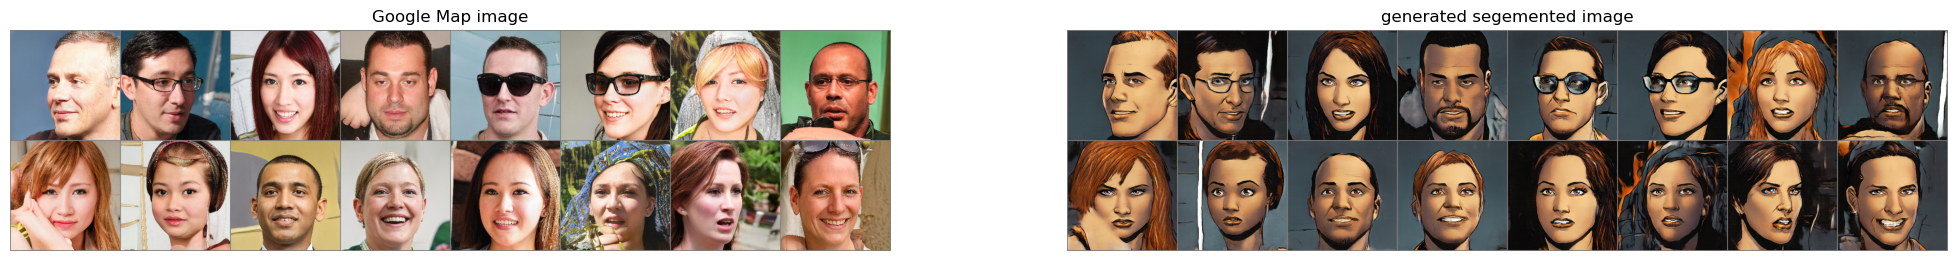

In [52]:
from torchvision.utils import make_grid

# Display images
def show_images(real_images, fake_images):


    

    # Create a grid of images
    real_grid = make_grid(real_images, nrow=8)
    fake_grid = make_grid(fake_images, nrow=8)

    plt.figure(figsize=(25,25))

    # Plot real images
    plt.subplot(1, 2, 1)
    plt.title("Google Map image")
    plt.imshow((real_grid*0.5+0.5).permute(1, 2, 0).detach())
    plt.axis('off')

    # Plot fake images
    plt.subplot(1, 2, 2)
    plt.title("generated segemented image")
    plt.imshow((fake_grid*0.5+0.5).cpu().permute(1, 2, 0).detach())
    plt.axis('off')

    plt.show()

# Hyperparameters
batch_size = 32
noise_dim = 100

show_images(x,y_fake)

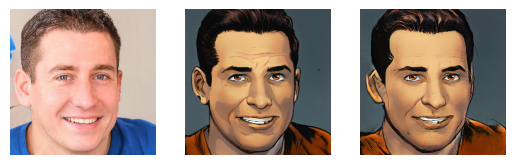

In [241]:
x,y=next(iter(val_data_loader))
import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.imshow((x[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow((y[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
y_fake=gen(x.to(device))
plt.subplot(1,3,3)
plt.imshow((y_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
plt.axis('off')
plt.show()

In [190]:
class process(Dataset):
    def __init__(self, input_dir):
        self.input_dir = input_dir
        self.input_files = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, index):
        input_img_file = self.input_files[index]


        input_img_path = os.path.join(self.input_dir, input_img_file)

        input_image = np.array(Image.open(input_img_path))

        # Apply augmentations if necessary
        augmentations = both_x_and_y_transform(image=input_image)
        input_image = augmentations["image"]
        if input_image.shape[-1] == 4:
            input_image = input_image[..., :3]
        # target_image = augmentations["image0"]

        # Apply specific transforms if needed
        input_image = transform_X(image=input_image)["image"]
        # target_image = transform_Y(image=target_image)["image"]

        return input_image


In [215]:
test_dataset=process(input_dir="data_comics/test_faces")
test_data_loader=DataLoader(dataset=test_dataset,batch_size=2,shuffle=True)

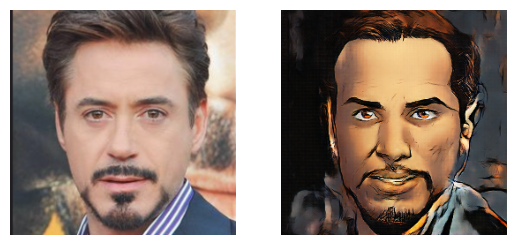

In [246]:
x=next(iter(test_data_loader))
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow((x[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
# plt.subplot(1,3,2)
# plt.imshow((y[0]*0.5+0.5).permute(1,2,0))
# plt.axis('off')
y_fake=gen(x.to(device))
plt.subplot(1,2,2)
plt.imshow((y_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
plt.axis('off')
plt.show()